In [77]:
#| default_exp examples.mcp_agent

## MCP Agent

This example demonstrates how to create a stringdale diagram that implements a complete MCP tool selection cycle:
1. User query input
2. LLM selects tool from available MCP tools
3. Execute selected tool via MCP client
4. Analyze tool output
5. Loop back or return final answer


In [78]:
#| hide
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
#| hide
from stringdale.core import get_git_root, load_env, checkLogs
load_env()


True

In [80]:
#| export
from typing import Optional, List, Dict, Any
from pydantic import BaseModel, Field, ConfigDict
from stringdale import Define, V, E, Condition, Scope
from stringdale.chat import Chat
import os

from fastmcp import Client
import asyncio


MCP_Chat
chosing a tool/tools from presented and executing them

In [81]:
#| export
def format_chat_messages(llm_response):
    """Format chat messages into OpenAI message format"""
    return {"role": llm_response['role'], "content": llm_response['content']}


In [82]:
#| export
def has_tool_calls(llm_response):
    return bool(llm_response.get('tool_calls', []))

In [83]:
#| export
def format_tool_output(tool_result):
    """
    Format the tool output messages for OpenAI format.

    Args:
        tool_result (list): List of dictionaries from execute_mcp_tool, each containing:
            - tool_id (str): The ID of the tool call
            - tool_name (str): The name of the tool
            - tool_content_texts (list): The output content from the tool
            - tool_args (dict): The arguments passed to the tool

    Returns:
        list: List of formatted messages in OpenAI format
    """
    messages = []
    for result in tool_result:
        messages.append({
            "role": "tool",
            "tool_call_id": result.get("tool_id"),
            "name": result.get("tool_name"),
            "content": result.get("tool_content_texts")
        })
    return messages

In [84]:
#| export
def MCP_Chat_factory(mcp_tool_selector_chat,execute_mcp_tool):
    # Factory that returns the MCP Agent diagram definition
    with Define('MCP Agent', type='decision') as MCP_Chat:
        # Start: User query comes in
        # Select tool: Chat with MCP tools to decide which tool to use
        V('select_tool', mcp_tool_selector_chat,
          inputs=['Start(messages=.)'],
          outputs=[
              ('format_chat_messages'),
              ('start_parallel_tools(tools=content)', Condition(has_tool_calls, '(llm_response=content)'))
          ])
        V('format_chat_messages', format_chat_messages,
          outputs=['End(messages = .)'])
        # Execute the selected tool
        V('start_parallel_tools',
        )
        with Scope('flow'):
            V('execute_tool', execute_mcp_tool,
              inputs=['start_parallel_tools(tool = tools.tool_calls)'],
              outputs=['format_tool_output(tool_result=.)'],
              for_each=['tool']
            )
            # Format the final answer for the user
        V('format_tool_output',format_tool_output,
          outputs=['End(messages = .)'])
    return MCP_Chat

Using local weather mcp tool

In [85]:
weather_path = str(get_git_root()/"stringdale/mcp_weather_server.py")
config = {
  "mcpServers": {
    "weather": {
      "command": "python",
      "args": [weather_path]
    }
  }
}
mcp_client = Client(config)
async with mcp_client:
    mcp_tools = await mcp_client.list_tools()



In [86]:
# Chat node for tool selection with MCP tools
# This chat will be used in the diagram to select tools
tool_selector = Chat(
    model="gpt-4o-mini",
    tools=mcp_tools
)

In [87]:
#| export
async def execute_mcp_tool(tool):
    """
    Extracts the tool name and arguments from the tool dict,
    executes the tool via mcp_client, and returns both:
        1. the OpenAI tool_result-style message, and 
        2. the raw tool_result itself.
    """
    tool_name = tool['name']
    tool_args = tool['input']
    tool_id = tool['id']
    async with mcp_client:
        tool_result = await mcp_client.call_tool(tool_name, tool_args)
    
    # Extract content from tool_result.content
    # MCP supports multiple content types: text, images, audio, resource references, etc.
    # For backwards compatibility, tool_content_texts contains only text strings
    content_texts = []
    content_items = []  # Full structured content with type information
    
    for item in tool_result.content:
        if hasattr(item, 'text'):
            # Text content - add to both for backwards compatibility
            content_texts.append(item.text)
            content_items.append({
                'type': 'text',
                'text': item.text
            })
        elif hasattr(item, 'data'):
            # Image or other binary data (ImageResource, etc.)
            content_items.append({
                'type': 'image' if hasattr(item, 'mimeType') and 'image' in getattr(item, 'mimeType', '') else 'binary',
                'data': item.data,
                'mimeType': getattr(item, 'mimeType', None),
                'url': getattr(item, 'url', None)
            })
        else:
            # Unknown content type - try to serialize what we can
            content_items.append({
                'type': 'unknown',
                'raw': str(item)
            })
    
    return {
        "tool_name": tool_name,
        "tool_args": tool_args,
        "tool_id": tool_id,
        "tool_content_texts": content_texts,  # Backwards compatible: list of text strings
        "tool_content_items": content_items,  # Full content with type information
    }


In [88]:
mcp_tools

[Tool(name='get_alerts', title=None, description='Get weather alerts for a US state.\n\n    Args:\n        state: Two-letter US state code (e.g. CA, NY)\n    ', inputSchema={'properties': {'state': {'title': 'State', 'type': 'string'}}, 'required': ['state'], 'title': 'get_alertsArguments', 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'string'}}, 'required': ['result'], 'title': 'get_alertsOutput', 'type': 'object'}, icons=None, annotations=None, meta=None),
 Tool(name='get_forecast', title=None, description='Get weather forecast for a location.\n\n    Args:\n        latitude: Latitude of the location\n        longitude: Longitude of the location\n    ', inputSchema={'properties': {'latitude': {'title': 'Latitude', 'type': 'number'}, 'longitude': {'title': 'Longitude', 'type': 'number'}}, 'required': ['latitude', 'longitude'], 'title': 'get_forecastArguments', 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 

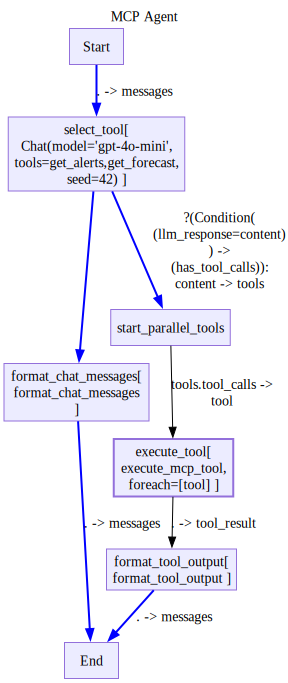

In [89]:
#execute_mcp_tool = execute_mcp_tool(mcp_client)
mcp_chat = MCP_Chat_factory(tool_selector,execute_mcp_tool)
mcp_chat.draw(direction='TB')

In [90]:
# Doesn't require using a tool
d0 = mcp_chat()
user_input = "What is love?"
messages = [
    {"role": "user", "content": user_input}
]
traces = []
for trace in d0.run(messages):
    trace.pprint(skip_passthrough=True,drop_keys=['input'])
    traces.append(trace)

# Assert that no tool was executed
executed_tools = [t for t in traces if 'execute_tool' in t.name]
assert len(executed_tools) == 0, f"Expected no tool execution, but found {len(executed_tools)} tool execution(s): {[t.name for t in executed_tools]}"

In [91]:
# Selects and executes a tool
d1 = mcp_chat()
user_input = "What is the weather like in Seattle?"
messages = [
    {"role": "user", "content": user_input}
]
traces = []
for trace in d1.run(messages):
    trace.pprint(skip_passthrough=True,drop_keys=['input'])
    traces.append(trace)


# ensure a tool was selected and executed
assert any('select_tool' in t.node_name for t in traces), "Tool selection missing"
assert any('execute_tool' in t.node_name for t in traces), "Tool execution missing"

# MCP Chat Loop
A loop that runs MCP chat until the response is obtained

In [92]:
# State class to manage conversation history
class CustomState(BaseModel):
    model_config = ConfigDict(extra='allow')
    history:list[int] = list()

    def append_to_history(self, value: int | list[int]):
        if isinstance(value, list):
            self.history.extend(value)
        else:
            self.history.append(value)
    
    def get_history(self)->int:
        return self.history

In [93]:
mcp_chat = MCP_Chat_factory(tool_selector,execute_mcp_tool)

In [94]:
#| export
def has_tool_result(mcp_output: Dict[str, Any]) -> bool:
    """
    Check if the mcp_chat output contains at least one tool_result in messages.
    
    Args:
        mcp_output: Output from mcp_chat sub-diagram, should have a 'messages' key
        
    Returns:
        True if any message has content with type 'tool_result', False otherwise
    """    
    messages = mcp_output.get('messages', [])
    # Iterate through each message
    for message in messages:
        if not isinstance(message, dict):
            continue
            
        content = message.get('content', [])
        
        # Handle content as a list
        if isinstance(content, list):
            for item in content:
                if isinstance(item, dict) and item.get('type') == 'tool_result':
                    return True
        
        # Handle content as a string (no tool_result)
        elif isinstance(content, str):
            continue
    
    return False

In [95]:

with Define('MCP Chat Loop', type='decision', state=CustomState()) as MCP_Chat_Loop:
    # Get user info/input
  E('Start->state/append_to_history')
    
    # Run MCP Chat as a sub-diagram
  V('mcp_chat', mcp_chat,
      inputs=['Start(_=.)',
      'State/get_history'],
      outputs=['State/append_to_history(0=messages)']
      )
  E('mcp_chat->mcp_chat', Condition(has_tool_result))
  E('mcp_chat->End')




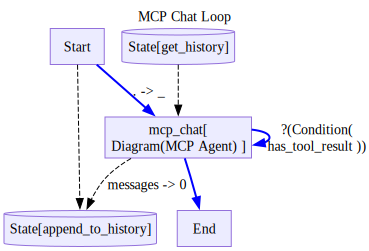

In [96]:
MCP_Chat_Loop.draw(direction='TB')

In [97]:
d = MCP_Chat_Loop()
user_input = "What is the weather going to be like in Seattle tomorrow?"
message = {"role": "user", "content": user_input}
for trace in d.run(message):
    trace.pprint(skip_passthrough=True,drop_keys=['input'])

/Users/olgasoldatenko/work/newer/stringdale/stringdale/base.py:86: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  type_fields = obj.model_fields


In [98]:
# |hide
import nbdev

nbdev.nbdev_export()